In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd

In [8]:
def get_coefficients(exponent_number, c0, c_fraction):
    coefficients = []
    coefficients.append(c0)
    squares_sum = c0**2
    for i in range(1, exponent_number -1):
        c = math.sqrt(1 - squares_sum) * c_fraction
        coefficients.append(c)
        squares_sum += c**2
    coefficients.append(math.sqrt(1 - squares_sum))
    return coefficients

def smearing_func(x, y0):
    return -(1-y0)/10000*x**2+(1-y0)/50*x+y0

def get_c0_smearing_dependence(smearing_steps, c0):
    c_smeared = []
    y0 = math.sqrt(c0)
    for x in smearing_steps:
        tmp = []
        for y in smearing_steps:
            tmp.append(smearing_func(x, y0) * smearing_func(y, y0))
        c_smeared.append(tmp)
    return c_smeared

def get_coefficients_smeared(c0_smeared, exponent_number, c_fraction):
    coefficients = []
    for i in range(len(c0_smeared)):
        tmp = []
        for j in range(len(c0_smeared[i])):
            tmp.append(get_coefficients(exponent_number, c0_smeared[i][j], c_fraction))
        coefficients.append(tmp)
    return coefficients

def potential_func(x, alpha, sigma, V0):
    return V0 + alpha / x + sigma * x

def sigma_dependence(n):
    return 0.0125 * (n + 1)

def alpha_dependence(n):
    return -0.25 * (n + 1)

def V0_dependence(n):
    return 0.2 * (n + 1)

def get_wilson_loops_mean(Nt, Ns, exponent_number, coefficients_smeared):
    expotent_enumeration = np.arange(exponent_number, dtype=float)
    sigma_i = sigma_dependence(expotent_enumeration)
    alpha_i = alpha_dependence(expotent_enumeration)
    V0_i = V0_dependence(expotent_enumeration)
    W = np.zeros((Nt, Ns, coefficients_smeared.shape[0], coefficients_smeared.shape[1]))
    for T in range(Nt):
        for R in range(Ns):
            W[T, R] = np.sum(np.exp(-potential_func(R + 1, alpha_i, sigma_i, V0_i) * (T + 1)) * coefficients_smeared, 2)
    return W

def get_relative_error(Nt, Ns, min, k):
    relative_error = np.zeros((Ns, Nt))
    a = math.sqrt(min)
    for i in range(Nt):
        for j in range(Ns):
            relative_error[i][j] = (a * (i + 1)**k) * (a * (j + 1)**k)
    return relative_error

def get_std(Nt, Ns, min, k, W):
    relative_error = get_relative_error(Nt, Ns, min, k)
    std = np.zeros(W.shape)
    # print(std)
    for i in range(Nt):
        for j in range(Ns):
            for m in range(W.shape[2]):
                for n in range(W.shape[3]):
                    std[i][j][m][n] = W[i][j][m][n] * relative_error[i][j]
    return std

def generate_data(W, std_arr):
    return np.random.default_rng().normal(W, std_arr)

def make_data_frame(data, smearing_steps):
    Nt_arr = []
    Ns_arr = []
    smearing1 = []
    smearing2 = []
    W = []
    for j in range(data.shape[0]):
        for k in range(data.shape[1]):
            for m in range(data.shape[2]):
                for n in range(data.shape[3]):
                    Nt_arr.append(j + 1)
                    Ns_arr.append(k + 1)
                    smearing1.append(smearing_steps[m])
                    smearing2.append(smearing_steps[n])
                    W.append(data[j][k][m][n])
    return pd.DataFrame({'smearing_step1': smearing1, 'smearing_step2': smearing2, 'time_size': Nt_arr, 'space_size': Ns_arr, 'wilson_loop': W})

In [10]:
Ns = 30
Nt = 30
N = 50000
exponent_number = 3
c0 = 0.3
c_fraction = 0.8
smearing_steps = [20, 50, 90]
coefficients_smeared = np.array(get_coefficients_smeared(get_c0_smearing_dependence(smearing_steps, c0), exponent_number, c_fraction))
W = get_wilson_loops_mean(Nt, Ns, exponent_number, coefficients_smeared)
std_arr = get_std(Nt, Ns, 0.001, 1.01, W)
for i in range(N):
    data = generate_data(W, std_arr)
    df = make_data_frame(data, smearing_steps)
    df = df[df['smearing_step2'] >= df['smearing_step1']]
    df.to_csv(f'/home/ilya/soft/lattice/observables/data/synthetic/wilson_gevp/conf_{(i+1):05}', index=False)

[0.3101250274787133, 0.3042653031222051, 0.29967886506105573, 0.296122247306575, 0.2933840568619446, 0.29128766070653395, 0.289689461365102, 0.2884750229436367, 0.28755447655379945, 0.2868580086315503, 0.286331821855969, 0.28593471009458693, 0.285635253542209, 0.2854095753466574, 0.2852395767136675, 0.28511156473071053, 0.2850151946140498, 0.2849426594257038, 0.2848880722254939]


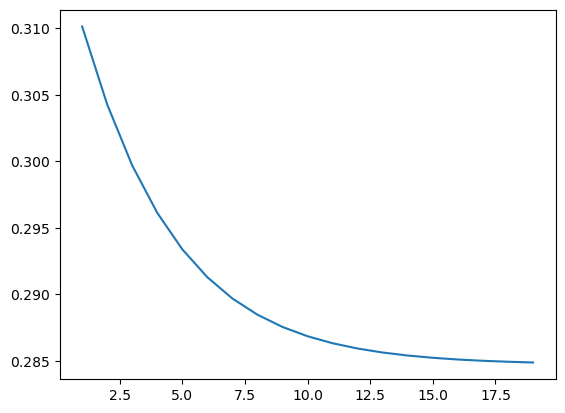

In [ ]:
y = []
x = []
for i in range(Nt-1):
    x.append(i + 1)
    y.append(math.log(W[i][8][1][1]/W[i+1][8][1][1]))
print(y)
plt.plot(x, y)